In [29]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

In [57]:
Final_Data = pd.read_csv('../input/u.data',delimiter='\t',header=None)

In [31]:
Final_Data.head()

,0,1,2,3
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


------------------------------
The full u data set, 100000 ratings by 943 users on 1682 items.<br>
Each user has rated at least 20 movies.  Users and items are<br>
numbered consecutively from 1.  The data is randomly<br>
ordered. This is a tab separated list of <br>
user id | item id | rating | timestamp. <br>
The time stamps are unix seconds since 1/1/1970 UTC<br>

-----------------------

<h2>Basic Stats

In [32]:
print("Number of NaN values = "+str(Final_Data.isnull().sum()))

Number of NaN values = 0    0
1    0
2    0
3    0
dtype: int64


In [33]:
print("Total Data:")
print("Total number of movie ratings = "+str(Final_Data.shape[0]))
print("Number of unique users = "+str(len(np.unique(Final_Data[0]))))
print("Number of unique movies = "+str(len(np.unique(Final_Data[1]))))

Total Data:
Total number of movie ratings = 100000
Number of unique users = 943
Number of unique movies = 1682


In [34]:
def changingLabels(number):
    return str(number/10**3) + "K"

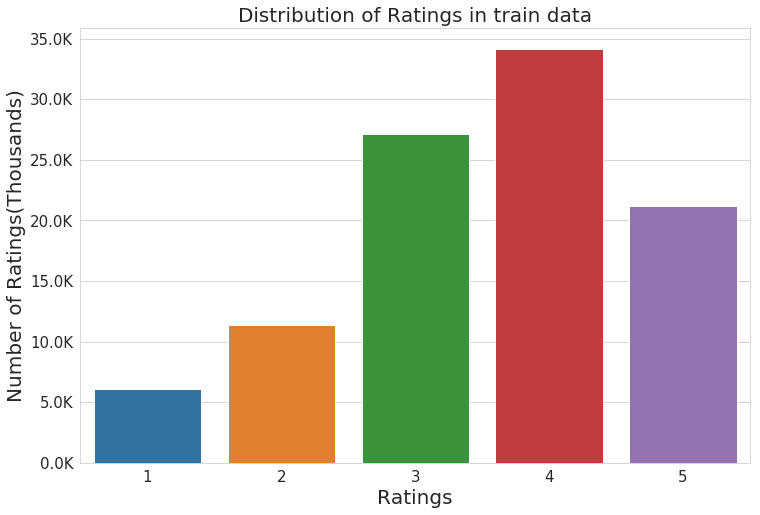

In [35]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x=2, data=Final_Data)

ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])

plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings in train data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings(Thousands)", fontsize = 20)
plt.show()

In [36]:
date = []
for i in Final_Data[3]:
    t = datetime.utcfromtimestamp(i)
    date.append(t)
del Final_Data[3]
Final_Data.columns

Int64Index([0, 1, 2], dtype='int64')

In [37]:
Final_Data['Date'] = date

In [38]:
Final_Data['Date'].head()

0   1997-12-04 15:55:49
1   1998-04-04 19:22:22
2   1997-11-07 07:18:36
3   1997-11-27 05:02:03
4   1998-02-02 05:33:16
Name: Date, dtype: datetime64[ns]

In [39]:
Final_Data["DayOfWeek"] = Final_Data.Date.dt.weekday_name

In [42]:
Final_Data[2].head()

0    3
1    3
2    1
3    2
4    1
Name: 2, dtype: int64

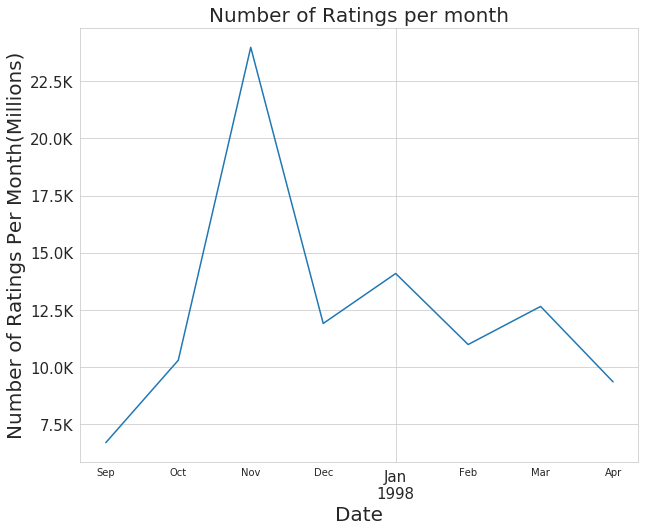

In [41]:
plt.figure(figsize = (10,8))
ax = Final_Data.resample("M", on = "Date")[2].count().plot()
#this above resample() function is a sort of group-by operation.Resample() function can work with dates. It can take months,
#days and years values independently. Here, in parameter we have given "M" which means it will group all the rows Monthly using 
#"Date" which is already present in the DataFrame. Now after grouping the rows month wise, we have just counted the ratings 
#which are grouped by months and plotted them. So, below plot shows that how many ratings are there per month. 
#In resample(), we can also give "6M" for grouping the rows every 6-Monthly, we can also give "Y" for grouping
#the rows yearly, we can also give "D" for grouping the rows by day.
#Resample() is a function which is designed to work with time and dates.
#This "Train_Data.resample("M", on = "Date")["Ratings"].count()" returns a pandas series where keys are Dates and values are 
#counts of ratings grouped by months.You can even check it and print it. Then we are plotting it, where it automatically takes
#Dates--which are keys on--x-axis and counts--which are values on--y-axis.
ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
ax.set_title("Number of Ratings per month", fontsize = 20)
ax.set_xlabel("Date", fontsize = 20)
ax.set_ylabel("Number of Ratings Per Month(Millions)", fontsize = 20)
plt.tick_params(labelsize = 15)
plt.show()

### Analysis of Ratings given by user

* Below PDF graph shows that almost all of the users give very few ratings. There are very few users who's ratings count is high.
* Similarly, above CDF graph shows that almost 99% of users give very few ratings.

In [44]:
no_of_rated_movies_per_user = Final_Data.groupby(by = 0)[1].count().sort_values(ascending = False)

In [45]:
no_of_rated_movies_per_user.head()

0
405    737
655    685
13     636
450    540
276    518
Name: 1, dtype: int64

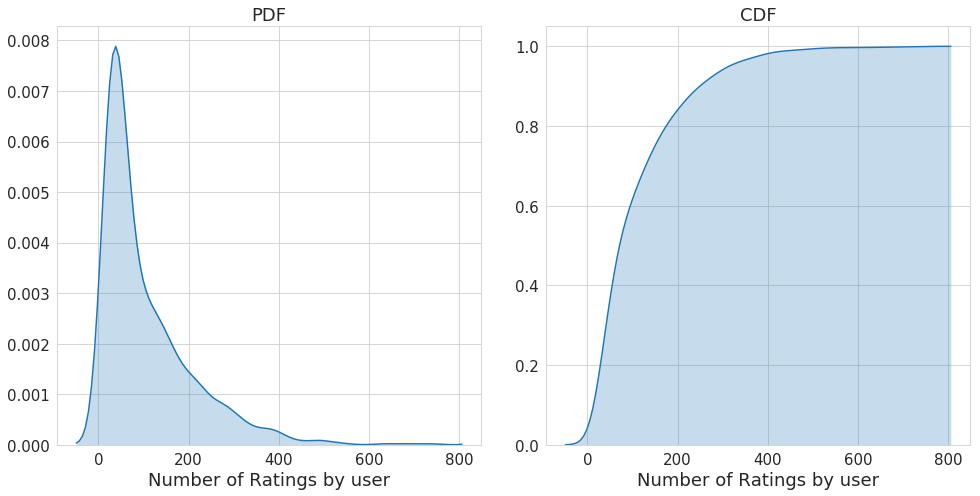

In [46]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(14,7))

sns.kdeplot(no_of_rated_movies_per_user.values, shade = True, ax = axes[0])
axes[0].set_title("PDF", fontsize = 18)
axes[0].set_xlabel("Number of Ratings by user", fontsize = 18)
axes[0].tick_params(labelsize = 15)

sns.kdeplot(no_of_rated_movies_per_user.values, shade = True, cumulative = True, ax = axes[1])
axes[1].set_title("CDF", fontsize = 18)
axes[1].set_xlabel("Number of Ratings by user", fontsize = 18)
axes[1].tick_params(labelsize = 15)

fig.subplots_adjust(wspace=2)
plt.tight_layout()
plt.show()

In [47]:
print("Information about movie ratings grouped by users:")
no_of_rated_movies_per_user.describe()

Information about movie ratings grouped by users:


count    943.000000
mean     106.044539
std      100.931743
min       20.000000
25%       33.000000
50%       65.000000
75%      148.000000
max      737.000000
Name: 1, dtype: float64

In [48]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01))

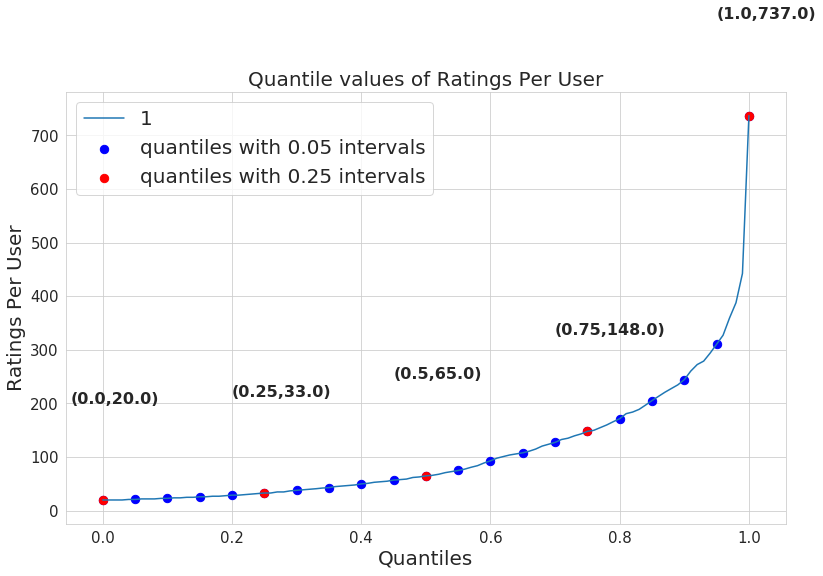

In [49]:
fig = plt.figure(figsize = (10, 6))

axes = fig.add_axes([0.1,0.1,1,1])
axes.set_title("Quantile values of Ratings Per User", fontsize = 20)
axes.set_xlabel("Quantiles", fontsize = 20)
axes.set_ylabel("Ratings Per User", fontsize = 20)
axes.plot(quantiles)

plt.scatter(x = quantiles.index[::5], y = quantiles.values[::5], c = "blue", s = 70, label="quantiles with 0.05 intervals")
plt.scatter(x = quantiles.index[::25], y = quantiles.values[::25], c = "red", s = 70, label="quantiles with 0.25 intervals")
plt.legend(loc='upper left', fontsize = 20)

for x, y in zip(quantiles.index[::25], quantiles.values[::25]):
    plt.annotate(s = '({},{})'.format(x, y), xy = (x, y), fontweight='bold', fontsize = 16, xytext=(x-0.05, y+180))
    
axes.tick_params(labelsize = 15)

In [50]:
print("Total number of ratings below 75th percentile = "+str(sum(no_of_rated_movies_per_user.values<=133)))
print("Total number of ratings above 75th percentile = "+str(sum(no_of_rated_movies_per_user.values>133)))

Total number of ratings below 75th percentile = 673
Total number of ratings above 75th percentile = 270


### Analysis of Ratings Per Movie

In [53]:
no_of_ratings_per_movie = Final_Data.groupby(by = 1)[2].count().sort_values(ascending = False)

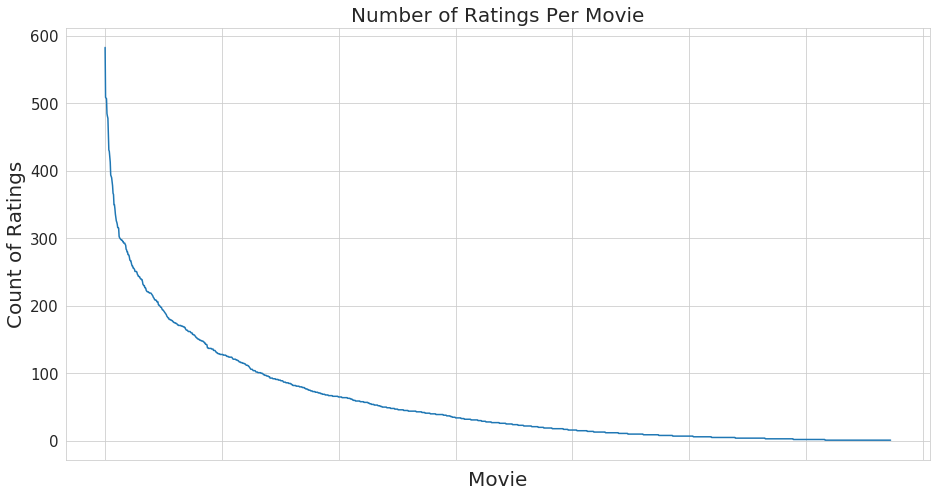

In [54]:
fig = plt.figure(figsize = (12, 6))
axes = fig.add_axes([0.1,0.1,1,1])
plt.title("Number of Ratings Per Movie", fontsize = 20)
plt.xlabel("Movie", fontsize = 20)
plt.ylabel("Count of Ratings", fontsize = 20)
plt.plot(no_of_ratings_per_movie.values)
plt.tick_params(labelsize = 15)
axes.set_xticklabels([])
plt.show()

Some movies are very popular and rated by many users vs other movies

### Analysis of Movie Ratings on Day of Week

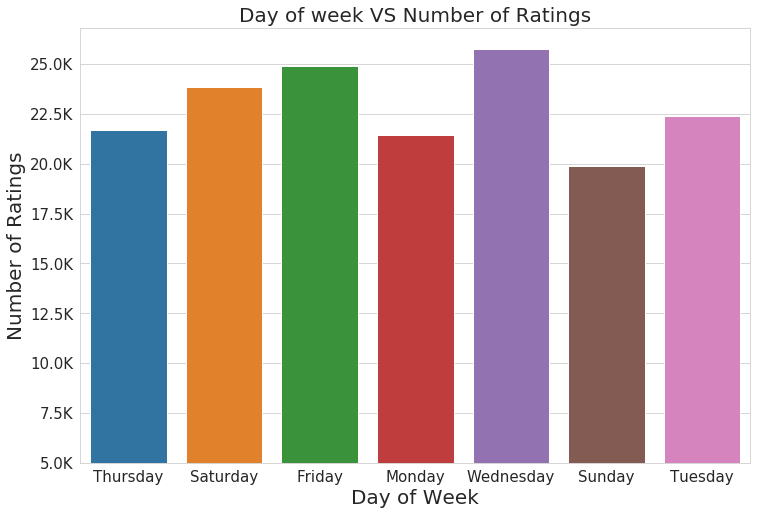

In [56]:
fig = plt.figure(figsize = (12, 8))

axes = sns.countplot(x = "DayOfWeek", data = Final_Data)
axes.set_title("Day of week VS Number of Ratings", fontsize = 20)
axes.set_xlabel("Day of Week", fontsize = 20)
axes.set_ylabel("Number of Ratings", fontsize = 20)
axes.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
axes.tick_params(labelsize = 15)

plt.show()